In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from mcl import *

In [2]:
class Goal:  ###goal4
    def __init__(self, x, y, radius=0.3, value=0.0):
        self.pos = np.array([x, y]).T
        self.radius = radius
        self.value = value
        
    def inside(self, pose): #追加
        return self.radius > math.sqrt( (self.pos[0]-pose[0])**2 + (self.pos[1]-pose[1])**2 )

    def draw(self, ax, elems):
        x, y = self.pos
        c = ax.scatter(x + 0.16, y + 0.5, s=50, marker=">", label="landmarks", color="red") 
        elems.append(c)
        elems += ax.plot([x, x], [y, y + 0.6], color="black")

In [3]:
class Puddle:
    def __init__(self, lowerleft, upperright, depth):
        self.lowerleft = lowerleft
        self.upperright = upperright
        self.depth = depth
        
    def draw(self, ax, elems):
        w = self.upperright[0] - self.lowerleft[0]
        h = self.upperright[1] - self.lowerleft[1]
        r = patches.Rectangle(self.lowerleft, w, h, color="blue", alpha=self.depth)
        elems.append(ax.add_patch(r))
        
    def inside(self, pose):
        return all([ self.lowerleft[i] < pose[i] < self.upperright[i]  for i in [0, 1] ])

In [4]:
class PuddleWorld(World): ###puddleworld4
    def __init__(self, time_span, time_interval):
        super().__init__(time_span, time_interval)
        self.puddles = []
        self.robots = []
        self.goals = []
        
    def append(self,obj):
        self.objects.append(obj)
        if isinstance(obj, Puddle): self.puddles.append(obj)
        if isinstance(obj, PuddleRobot): self.robots.append(obj)
        if isinstance(obj, Goal): self.goals.append(obj)
        
    def puddle_depth(self, pose):
        return sum([p.depth * p.inside(pose) for p in self.puddles])
    
    def one_step(self, i, elems, ax):
        super().one_step(i, elems, ax)
        for r in self.robots:
            r.puddle_depth = self.puddle_depth(r.pose)
            for g in self.goals: #以下追加
                if g.inside(r.pose):
                    r.in_goal = True
                    r.final_value = g.value

In [5]:
class PuddleRobot(Robot): ###puddlerobot4
    def __init__(self, time_interval, pose, agent=None, sensor=None, color="black", \
                           noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1,0.1), \
                           expected_stuck_time=1e100, expected_escape_time = 1e-100,\
                           expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0), \
                           puddle_coef=100.0): 
        super().__init__(pose, agent, sensor, color, noise_per_meter, noise_std, bias_rate_stds, \
                         expected_stuck_time, expected_escape_time, expected_kidnap_time, kidnap_range_x, kidnap_range_y)
        
        self.puddle_depth = 0.0  
        self.puddle_coef = puddle_coef 
        self.total_reward = 0.0  
        self.time_interval = time_interval
        
        self.in_goal = False #以下2行追加
        self.final_value = 0.0
        
    def reward_per_sec(self):
        return -1.0 - self.puddle_depth*self.puddle_coef
    
    def one_step(self, time_interval):
        if self.in_goal: #if文追加
            return
            
        super().one_step(time_interval)
        rps = self.reward_per_sec()
        self.total_reward += rps*self.time_interval
        
    def draw(self, ax, elems): 
        super().draw(ax, elems)
        elems.append(ax.text(self.pose[0]+1.0, self.pose[1]-0.5, "reward/sec:" + str(self.reward_per_sec()), fontsize=8))
        elems.append(ax.text(self.pose[0]+1.0, self.pose[1]-1.0, "evaluation:" + str(self.total_reward+self.final_value), fontsize=8)) #変更

In [6]:
class PuddleIgnoreAgent(MclAgent):  ###puddleignoreagent
    def __init__(self, time_interval, particle_pose, envmap, goal, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}): #goal追加, 速度, 角速度の初期値は不要
        super().__init__(time_interval, 0.0, 0.0, particle_pose, envmap, particle_num, motion_noise_stds) #速度, 角速度の初期値をゼロに
        
        self.goal = goal
        
    @classmethod
    def policy(cls, pose, goal):
        x, y, theta = pose
        dx, dy = goal.pos[0] - x, goal.pos[1] - y
        direction = int((math.atan2(dy, dx) - theta)*180/math.pi)   #ゴールの方角（degreeに直す）
        direction = (direction + 360*1000 + 180)%360 - 180      #方角を-180〜180[deg]に正規化（適当。ロボットが-1000回転すると破綻）
        
        if direction > 10:      nu, omega = 0.0, 0.5
        elif direction < -10:  nu, omega = 0.0, -0.5
        else:                       nu, omega = 0.2, 0.0
            
        return nu, omega
        
    def decision(self, observation=None):
        nu, omega = self.policy(self.mcl.ml_pose, self.goal)
        self.mcl.motion_update(nu, omega, self.time_interval)
        self.mcl.observation_update(observation)
        
        return nu, omega

<IPython.core.display.Javascript object>


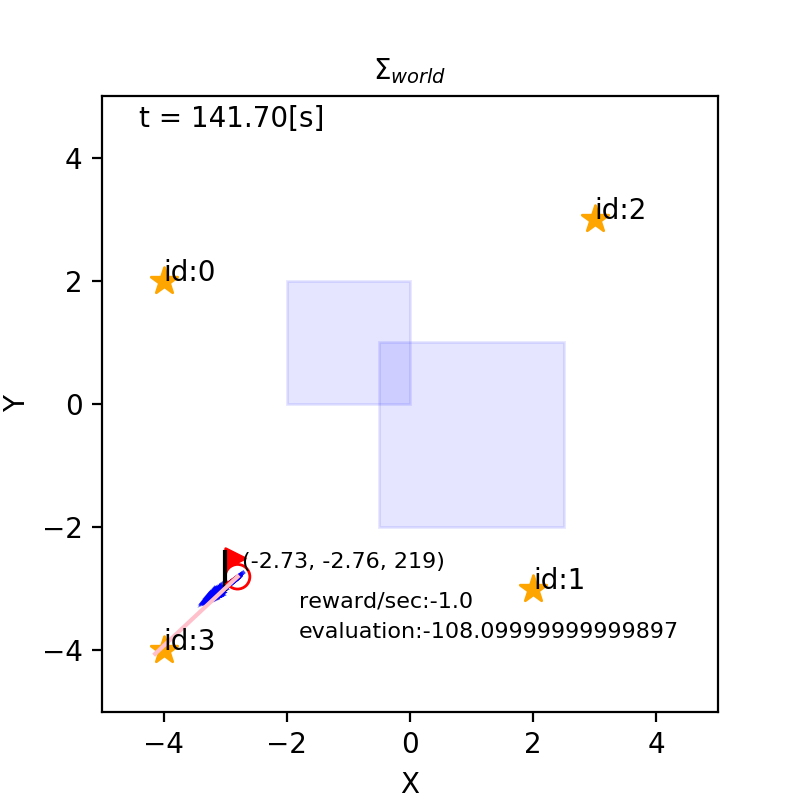

In [7]:
if __name__ == '__main__': ###changetopuddlerobot4
    time_interval = 0.1
    world = PuddleWorld(400, time_interval)  #長めにアニメーション時間をとる

    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    m.append_landmark(Landmark(-4,-4)) #追加（ゴール方向にランドマークがないので）
    world.append(m)
    
    ###ゴールの追加###
    goal = Goal(-3,-3)
    world.append(goal)
    
    ###水たまりの追加###
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1))

    ### ロボットを作る ###
    pia = PuddleIgnoreAgent(time_interval, np.array([0, 0, 0]).T, m, goal, particle_num=100)  #引数から速度、角速度を抜き、goalを追加
    r = PuddleRobot(time_interval, np.array([0,0,0]).T, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0),
              agent=pia, color="red", bias_rate_stds=(0,0)) #ロボットを変更

    world.append(r)
    
    world.draw()